## Problem description 

The goal of this project was to learn more about hand gestures and how to train a neural network to do such things. Initially the main idea was to just have a dataset of hand gestures images and run it through a network to classify them, however this seemed a little too simple so I decided to do a little more research on this topic. I decided to implement a neural network to learn image masking of the hands using Unet architecture. As I did more research I found out to see if I can train something that would be simple enough to run on a mobile device as it got me interested in running a simple model on my devices.

## Data preparation

Data used was EgoYouTubeHands dataset found on a hand segmentation repository found in github. This dataset contains the video frames in one folder and the hand mask's in another. The data would need to be processed and normalized. The data length is 1290 images and 1290 mask images. These images come in 3 channel rgb and the masks come out in black and white. The shape of the data input should be (256,256,3) and output would be (256,256,1). Issues arose in this part of the project as Keras does not a proper way to load in images and their masks at the same time so I had to figure a way to workaround on it. The images have been shuffled and normalized for the network. For the data around 10% is seperated and used for testing and another 10% for dev set for attempting different loss function, for training 20% used for validation during training.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files
import glob
import os
import random
import numpy as np
import tensorflow.keras as tf
import matplotlib.pyplot as plt
import json

from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import MobileNetV2

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle

from scipy import ndimage

In [ ]:
input_dir = "drive/MyDrive/Project2data/eyth_dataset/images/"
target_dir = "drive/MyDrive/Project2data/eyth_dataset/masks/"

input_paths = sorted(glob.glob(input_dir+'**/*'))
target_paths = sorted(glob.glob(input_dir+'**/*'))
len(input_paths)

1290

In [ ]:
def plotgraph(history_data):
  #plot the history for accuracy during training
  plt.plot(history_data['accuracy'])
  plt.plot(history_data['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validate'], loc='upper left')
  plt.show()

  #plot for loss
  plt.plot(history_data['loss'])
  plt.plot(history_data['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validate'], loc='upper left')
  plt.show()

#### Data input processing, initially tried to load all manually but I just used a workout with keras

In [ ]:
img_ds = image_dataset_from_directory(
    input_dir, 
    labels=None,
    seed = 1,
    batch_size = 1290,
    shuffle=1)

img_ds = img_ds.map(Rescaling(1./255))

mask_ds = image_dataset_from_directory(
    target_dir, 
    labels=None,
    seed = 1,
    batch_size = 1290, 
    shuffle=1, 
    color_mode='grayscale')

mask_ds = mask_ds.map(Rescaling(1./255))

# ds = zip((img_ds, mask_ds))

for x in img_ds:
  # print(type(x))
  X = x.numpy()

for y in mask_ds:
  Y = y.numpy()


Found 1290 files belonging to 1 classes.
Found 1290 files belonging to 1 classes.


In [ ]:
print(X.shape)
print(Y.shape)

(1290, 256, 256, 3)
(1290, 256, 256, 1)


In [ ]:
trainX, devX = train_test_split(X, test_size=0.2, random_state=1337)
trainY, devY = train_test_split(Y, test_size=0.2, random_state=1337)

devX, testX = train_test_split(devX, test_size=0.5, random_state=1337)
devY, testY = train_test_split(devY, test_size=0.5, random_state=1337)

print(devX.shape)
print(testY.shape)

(129, 256, 256, 3)
(129, 256, 256, 1)


In [ ]:
trainX.shape

(1032, 256, 256, 3)

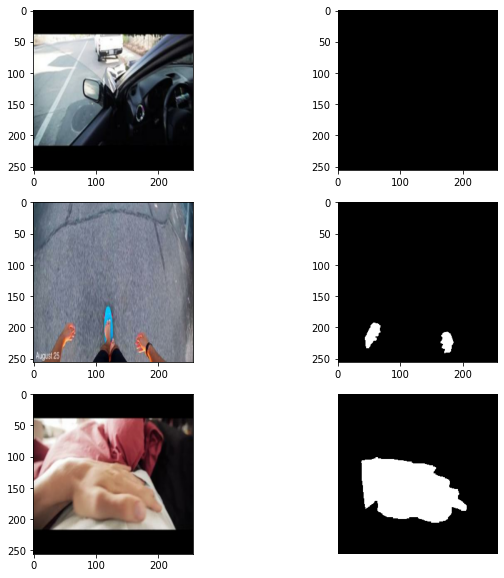

In [ ]:

fig, ax = plt.subplots(3, 2, figsize=(10, 10))

for i in range(3):
    ax[i,0].imshow((X[i]*255).astype("uint8"))
    ax[i,1].imshow(Y[i,:,:,0].astype("uint8"), cmap='gray')
    # plt.imshow()
    plt.axis("off")

#### Unet Architecture
Unet uses 3 tpyes of blocks, first we have the downsampling block for encoding, the mid block used in between the encoder and decoder section and lastly the upsampling block used for upsampling for the decoding layers. The architecture also utilizes skip connections from the downsampling layers to the upsampling layers. I decided to just use sigmoid activation with binary cross entropy for loss and adam optimized. For measuring the acurracy I used meanIoU which is the Intersection over union since we're doing segmentation. 25 epochs and adam optimizer with default learning rate is used here.

#### Result & Benchmarking
The metric used for this predictions mean Intersection over Union. For the predictions I put a threshold of 0.5 on the predictions of the pixels in order to display the masks.
This training run achieved an IoU of 0.75123435 on the test set. This will be used as a benchmark

penalty around boundary

In [ ]:
# opt = tf.optimizers.Adam(learning_rate=0.01)

def down_block(x, filters, padding="same"):
  x = Conv2D(filters, 3, padding="same", activation="relu")(x)
  x = Conv2D(filters, 3, padding="same", activation="relu")(x)
  p = MaxPool2D((2, 2), (2, 2))(x)
  return x, p

def up_block(x, skip, filters, padding="same"):
  us = UpSampling2D((2, 2))(x)
  concat = Concatenate()([us, skip])
  x = Conv2D(filters, 3, padding="same", activation="relu")(concat)
  x = Conv2D(filters, 3, padding="same", activation="relu")(x)
  return x

def mid_block(x, filters, padding="same"):
  x = Conv2D(filters, 3, padding="same", activation="relu")(x)
  x = Conv2D(filters, 3, padding="same", activation="relu")(x)
  return x

def unet(input_size = (256,256,3), filter = 16):
  
  f = filter

  inputs = Input(input_size)
  
  p0 = inputs
  d1, p1 = down_block(p0, 1*f)
  d2, p2 = down_block(p1, 2*f)
  d3, p3 = down_block(p2, 4*f)
  d4, p4 = down_block(p3, 8*f)
  
  mid = mid_block(p4, 16*f)
  
  u1 = up_block(mid, d4, 8*f)
  u2 = up_block(u1, d3, 4*f)
  u3 = up_block(u2, d2, 2*f)
  u4 = up_block(u3, d1, 1*f)
  
  outputs = Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
  model = Model(inputs, outputs)

  return model

In [ ]:
tf.backend.clear_session()
unetV1 = unet()
unetV1.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
unetV1.compile(optimizer = 'adam', loss = "binary_crossentropy", metrics = ['accuracy'])
H = unetV1.fit(trainX,trainY, epochs=25, batch_size=32 , validation_split = 0.2)
unetV1.save('drive/MyDrive/Project2data/unetV1')

H_dict = H.history

with open('drive/MyDrive/Project2data/unetV1history.json', 'w') as f:
  json.dump(H_dict, f)
# jsonpath.write_text(json.dump(history)



Epoch 1/25
26/26 [==============================] - 17s 267ms/step - loss: 0.3077 - accuracy: 0.9196 - val_loss: 0.1759 - val_accuracy: 0.9590
Epoch 2/25
26/26 [==============================] - 4s 163ms/step - loss: 0.1666 - accuracy: 0.9513 - val_loss: 0.1368 - val_accuracy: 0.9590
Epoch 3/25
26/26 [==============================] - 4s 162ms/step - loss: 0.1459 - accuracy: 0.9513 - val_loss: 0.1286 - val_accuracy: 0.9590
Epoch 4/25
26/26 [==============================] - 4s 163ms/step - loss: 0.1428 - accuracy: 0.9513 - val_loss: 0.1263 - val_accuracy: 0.9590
Epoch 5/25
26/26 [==============================] - 4s 163ms/step - loss: 0.1323 - accuracy: 0.9513 - val_loss: 0.1170 - val_accuracy: 0.9590
Epoch 6/25
26/26 [==============================] - 4s 163ms/step - loss: 0.1249 - accuracy: 0.9513 - val_loss: 0.1119 - val_accuracy: 0.9590
Epoch 7/25
26/26 [==============================] - 4s 163ms/step - loss: 0.1220 - accuracy: 0.9513 - val_loss: 0.1241 - val_accuracy: 0.9590
Epoch

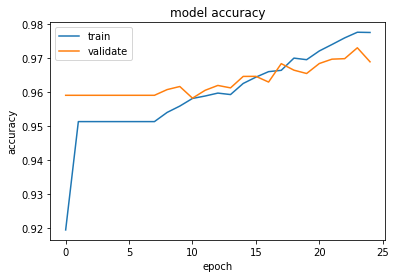

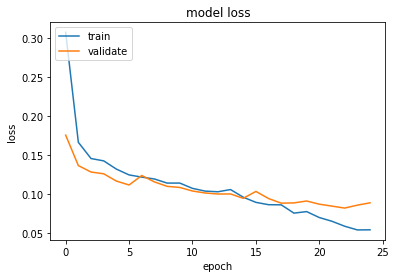

In [ ]:
history_data = json.load(open('drive/MyDrive/Project2data/unetV1history.json', 'r'))
plotgraph(history_data)

In [30]:
PredY = unetV1.predict(testX)
# print(testoutput[0][0][0])
PredY = PredY > 0.5

m = tf.metrics.MeanIoU(num_classes=2)
m.update_state(testY, PredY)
print("IoU:",m.result().numpy())

IoU: 0.75123435


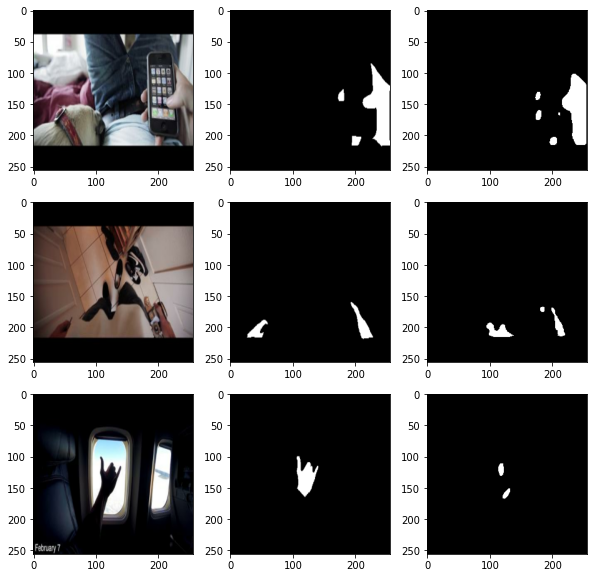

In [31]:
fig, ax = plt.subplots(3, 3, figsize=(10, 10))
for i in range(3):
    # plt.imshow(images[i].numpy().astype("uint8"))
    ax[i,0].imshow((testX[i+5]*255).astype("uint8"))
    # plt.imshow(mask[i].numpy().astype("uint8"), cmap='gray')
    ax[i,1].imshow((testY[i+5,:,:,0]*255).astype("uint8"), cmap='gray')
    ax[i,2].imshow((PredY[i+5,:,:,0]*255).astype("uint8"), cmap='gray')

#### Decided to see if I used Mobilenet as the encoder and then keep the decoder layers the same to see if anything happens
For Mobilenet I sliced off half it till Block 8 layer and used that part as the encoder and then kept the same upsampling from Unet. I used the weights from imagenet and only trained the decoder layer. I had to figure out the skip connections from the Mobilenet to the Unet decoder layer ,at first I didn't really know what was going on but I found that I had to use the layers from encoder with matching dimensions so that they can be used for skip connections from Mobilenet to the upsampling layers. I manually picked 4 layers for skip connections ("input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"). I used 10 epochs since the only trainable part is the expanding/decoder layers.

#### Result

This run didn't well as the validation accuracy on the test set at just didn't increase which could be due to insufficient data. Although this didn't achieve good results it, I learned how to use skip connections and how to combine network architectures.


IoU: 0.48203042

In [ ]:
# test = MobileNetV2(weights = 'imagenet', include_top = False,)

# print(test.summary())
# test.compile()

def MobileUnet():
    inputs = Input(shape=(256, 256, 3), name="input_image")
    
    encoder = MobileNetV2(input_tensor=inputs, weights="imagenet", include_top=False, alpha=0.35)

    skip_connection_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]

    encoder_output = encoder.get_layer("block_8_expand_relu").output
    

    x = encoder_output


    for i in range(1, len(skip_connection_names)+1, 1):

      skip = encoder.get_layer(skip_connection_names[-i]).output
      print(skip)
      us = UpSampling2D((2, 2))(x)
      x = Concatenate()([us, skip])
      x = Conv2D(i*32, 3, padding="same", activation="relu")(x)
      x = Conv2D(i*32, 3, padding="same", activation="relu")(x)


    outputs = Conv2D(1, (1, 1), padding="same", activation="sigmoid")(x)
    model = Model(inputs, outputs)
    return model


In [ ]:
tf.backend.clear_session()
munet = MobileUnet()
munet.summary()

2031616/2019640 [==============================] - 0s 0us/step
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 96), dtype=tf.float32, name=None), name='block_6_expand_relu/Relu6:0', description="created by layer 'block_6_expand_relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 48), dtype=tf.float32, name=None), name='block_3_expand_relu/Relu6:0', description="created by layer 'block_3_expand_relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128, 48), dtype=tf.float32, name=None), name='block_1_expand_relu/Relu6:0', description="created by layer 'block_1_expand_relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_image'), name='input_image', description="created by layer 'input_image'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputL

In [ ]:
munet.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
Hmunet = munet.fit(trainX,trainY, epochs=10, batch_size=32, validation_split=0.2)
munet.save('drive/MyDrive/Project2data/munetV1')

Hmunet_dict = Hmunet.history
with open('drive/MyDrive/Project2data/munetV1history.json', 'w') as f:
  json.dump(Hmunet_dict, f)
# jsonpath.write_text(json.dump(history)


Epoch 1/10
26/26 [==============================] - 26s 791ms/step - loss: 0.2334 - accuracy: 0.9161 - val_loss: 0.2049 - val_accuracy: 0.9590
Epoch 2/10
26/26 [==============================] - 15s 591ms/step - loss: 0.1280 - accuracy: 0.9513 - val_loss: 0.1277 - val_accuracy: 0.9590
Epoch 3/10
26/26 [==============================] - 15s 590ms/step - loss: 0.1024 - accuracy: 0.9513 - val_loss: 0.1408 - val_accuracy: 0.9590
Epoch 4/10
26/26 [==============================] - 15s 594ms/step - loss: 0.0887 - accuracy: 0.9611 - val_loss: 0.1493 - val_accuracy: 0.9593
Epoch 5/10
26/26 [==============================] - 15s 593ms/step - loss: 0.0780 - accuracy: 0.9678 - val_loss: 0.1869 - val_accuracy: 0.9593
Epoch 6/10
26/26 [==============================] - 15s 592ms/step - loss: 0.0712 - accuracy: 0.9708 - val_loss: 0.1661 - val_accuracy: 0.9595
Epoch 7/10
26/26 [==============================] - 15s 589ms/step - loss: 0.0671 - accuracy: 0.9729 - val_loss: 0.2656 - val_accuracy: 0.9592

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


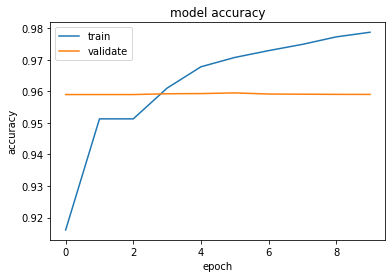

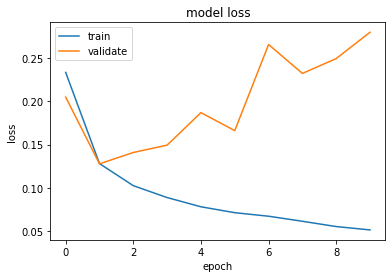

In [ ]:
history_data = json.load(open('drive/MyDrive/Project2data/munetV1history.json', 'r'))

plotgraph(history_data)

In [33]:
PredY = munet.predict(testX)
# print(testoutput[0][0][0])
PredY = PredY > 0.5

m = tf.metrics.MeanIoU(num_classes=2)
m.update_state(testY, PredY)
print("IoU:",m.result().numpy())

IoU: 0.48203042


#### Attempted to implement jaccard loss and dice loss on the following 2 runs
I attempted to run this part on the dev set to see if Jaccard distance function would do anything or improve the network. Used 25 epoch and adam optimizer with default learning rate of 0.001.

https://stackoverflow.com/questions/49284455/keras-custom-function-implementing-jaccard/50832690
https://gist.github.com/wassname/f1452b748efcbeb4cb9b1d059dce6f96


#### Result
IoU: 0.48022202

In [ ]:
from keras import backend as K
#https://stackoverflow.com/questions/49284455/keras-custom-function-implementing-jaccard/50832690
#https://gist.github.com/wassname/f1452b748efcbeb4cb9b1d059dce6f96
def jaccard_distance(y_true, y_pred, smooth=100):
  intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
  sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
  jac = (intersection + smooth) / (sum_ - intersection + smooth)
  return (1 - jac) * smooth


#https://gist.github.com/wassname/7793e2058c5c9dacb5212c0ac0b18a8a
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [ ]:
tf.backend.clear_session()
unetV2 = unet()

In [ ]:
unetV2.compile(optimizer = 'adam', loss = [jaccard_distance], metrics = ['accuracy'])
H = unetV2.fit(trainX,trainY, epochs=25, batch_size=32 , validation_data = (devX, devY))
unetV2.save('drive/MyDrive/Project2data/unetV2')

H_dict = H.history

with open('drive/MyDrive/Project2data/unetV2history.json', 'w') as f:
  json.dump(H_dict, f)
# jsonpath.write_text(json.dump(history)


Epoch 1/25
33/33 [==============================] - 7s 184ms/step - loss: 0.0814 - accuracy: 0.9524 - val_loss: 0.0433 - val_accuracy: 0.9536
Epoch 2/25
33/33 [==============================] - 5s 154ms/step - loss: 0.0440 - accuracy: 0.9528 - val_loss: 0.0433 - val_accuracy: 0.9536
Epoch 3/25
33/33 [==============================] - 5s 155ms/step - loss: 0.0440 - accuracy: 0.9528 - val_loss: 0.0433 - val_accuracy: 0.9536
Epoch 4/25
33/33 [==============================] - 5s 154ms/step - loss: 0.0440 - accuracy: 0.9528 - val_loss: 0.0433 - val_accuracy: 0.9536
Epoch 5/25
33/33 [==============================] - 5s 155ms/step - loss: 0.0440 - accuracy: 0.9528 - val_loss: 0.0433 - val_accuracy: 0.9536
Epoch 6/25
33/33 [==============================] - 5s 154ms/step - loss: 0.0440 - accuracy: 0.9528 - val_loss: 0.0433 - val_accuracy: 0.9536
Epoch 7/25
33/33 [==============================] - 5s 155ms/step - loss: 0.0440 - accuracy: 0.9528 - val_loss: 0.0433 - val_accuracy: 0.9536
Epoch 

In [34]:
PredY = unetV2.predict(testX)
# print(testoutput[0][0][0])
PredY = PredY > 0.5

m = tf.metrics.MeanIoU(num_classes=2)
m.update_state(testY, PredY)
print("IoU:",m.result().numpy())

IoU: 0.48022202


#### Dice loss run
Kept the same parameters as above to 25 epoch, adam optimizer with default learning rate of 0.001.

#### Result
IoU: 0.48022202


In [ ]:
tf.backend.clear_session()
unetV3 = unet()


In [ ]:
unetV3.compile(optimizer = 'adam', loss = [dice_coef_loss], metrics = ['accuracy'])
Hmunet = unetV3.fit(trainX,trainY, epochs=25, batch_size=32, validation_data = (devX, devY))
unetV3.save('drive/MyDrive/Project2data/unetV3')

H_dict = H.history

with open('drive/MyDrive/Project2data/unetV3history.json', 'w') as f:
  json.dump(H_dict, f)
# jsonpath.write_text(json.dump(history)


Epoch 1/25
33/33 [==============================] - 7s 165ms/step - loss: 0.0355 - accuracy: 0.9465 - val_loss: 0.0217 - val_accuracy: 0.9536
Epoch 2/25
33/33 [==============================] - 5s 155ms/step - loss: 0.0220 - accuracy: 0.9528 - val_loss: 0.0217 - val_accuracy: 0.9536
Epoch 3/25
33/33 [==============================] - 5s 155ms/step - loss: 0.0220 - accuracy: 0.9528 - val_loss: 0.0217 - val_accuracy: 0.9536
Epoch 4/25
33/33 [==============================] - 5s 154ms/step - loss: 0.0220 - accuracy: 0.9528 - val_loss: 0.0217 - val_accuracy: 0.9536
Epoch 5/25
33/33 [==============================] - 5s 154ms/step - loss: 0.0220 - accuracy: 0.9528 - val_loss: 0.0217 - val_accuracy: 0.9536
Epoch 6/25
33/33 [==============================] - 5s 154ms/step - loss: 0.0220 - accuracy: 0.9528 - val_loss: 0.0217 - val_accuracy: 0.9536
Epoch 7/25
33/33 [==============================] - 5s 155ms/step - loss: 0.0220 - accuracy: 0.9528 - val_loss: 0.0217 - val_accuracy: 0.9536
Epoch 

In [36]:
PredY = unetV3.predict(testX)
# print(testoutput[0][0][0])
PredY = PredY > 0.5

m = tf.metrics.MeanIoU(num_classes=2)
m.update_state(testY, PredY)
print("IoU:",m.result().numpy())

IoU: 0.48022202


In [ ]:
# tf.backend.clear_session()
# munetV2 = MobileUnet()
# # munetV2.summary()
# munetV2.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Hmunet = munetV2.fit(trainX,trainY, epochs=5, batch_size=32, validation_split = 0.2)
# munetV2.save('drive/MyDrive/Project2data/munetV2')

# Hmunet_dict = Hmunet.history

# with open('drive/MyDrive/Project2data/munetV2history.json', 'w') as f:
#   json.dump(Hmunet_dict, f)
# # jsonpath.write_text(json.dump(history)

# history_data = json.load(open('drive/MyDrive/Project2data/munetV2history.json', 'r'))
# #plot the history for accuracy during training
# plotgraph(history_data)


### Conclusion
To conclude, this project pushed me to learn a lot about Keras and how to implement network for different problems. I discovered that Keras doesn't play nicely for certain dataset and I had to figure how to work around it and load it in to Numpy arrays. Reading about Unet made me learn how to use skip connections and how to implement encoder and decoders. Having some rotations augmentation on the images maybe would've helped train the network more but was difficult at the same as I was attempting to figure how to keep images and mask mapped without mixing up the order with keras. Another thing that popped up is that dataset is only on individual's hands, thus may be biased towards certain skin tone. Overall I learned a lot attempting to this project even though I didn't get the expected results that I wanted.

### Sources
https://github.com/aurooj/Hand-Segmentation-in-the-Wild

https://keras.io/examples/vision/oxford_pets_image_segmentation

https://github.com/akirasosa/mobile-semantic-segmentation

https://github.com/nikhilroxtomar/Unet-with-Pretrained-Encoder

https://github.com/nikhilroxtomar/UNet-Segmentation-in-Keras-TensorFlow

https://github.com/keras-team/keras-contrib/blob/master/keras_contrib/losses/jaccard.py